In [1]:
import os, sys
import torch
from sklearn import metrics
import numpy as np
import math
import itertools
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from model import RFFGP_Reg
from loss import square_loss
from train import train_model

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

Using CPU
Final device: cpu


In [2]:
n_samples = 500
x = torch.linspace(0, 2 * torch.pi, n_samples).unsqueeze(1) 
y = torch.sin(x) + 0.15 * torch.randn_like(x) 


X_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)

n_train = int(n_samples * 0.6)
n_val = int(n_samples * 0.2)

indices = torch.randperm(n_samples)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

train_dataset = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
val_dataset = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])
test_dataset = TensorDataset(X_tensor[test_idx], y_tensor[test_idx])
    
train_loader = DataLoader(train_dataset, batch_size=1_000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1_000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1_000, shuffle=True)


/tmp/ipykernel_150735/637559625.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(x)
/tmp/ipykernel_150735/637559625.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y)


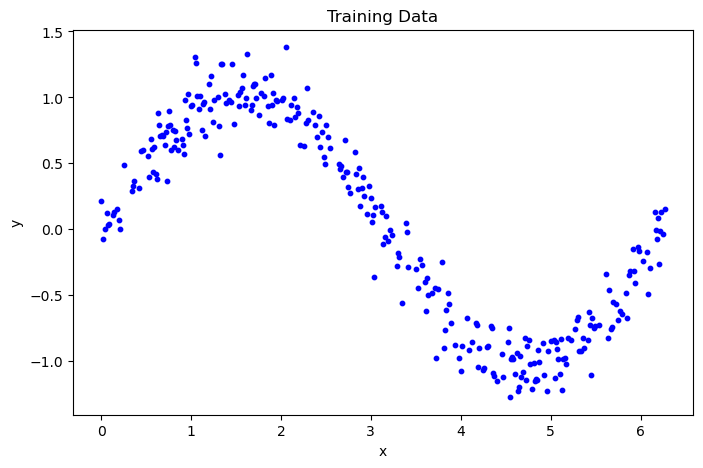

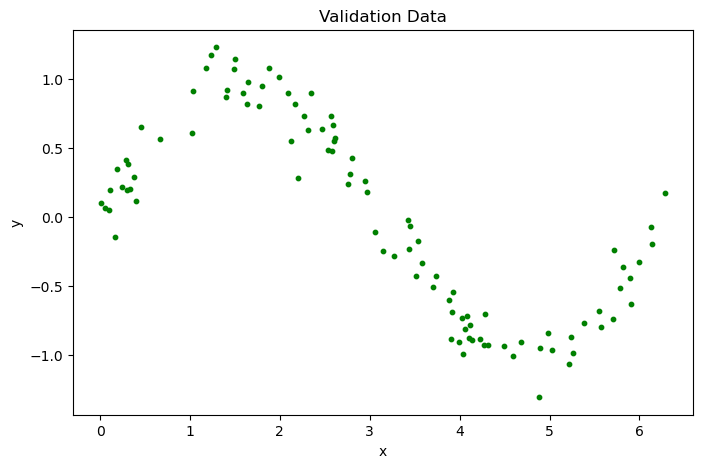

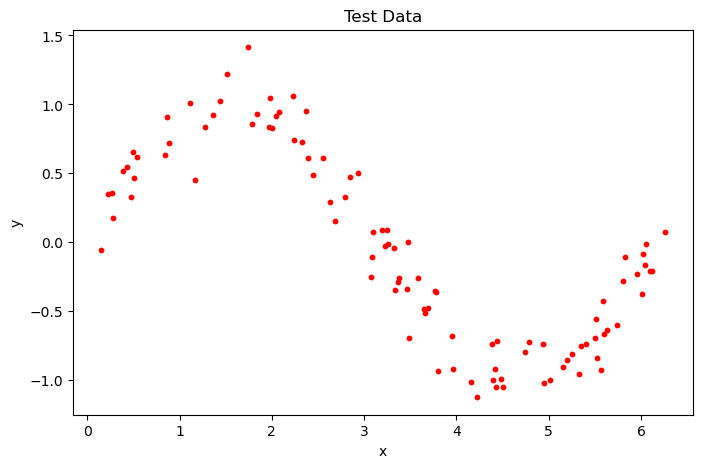

In [3]:
# --- Plotting code ---
# Helper to extract full tensors from a DataLoader
def get_full_batch(loader):
    for xb, yb in loader:
        return xb, yb

x_train, y_train = get_full_batch(train_loader)
x_val, y_val     = get_full_batch(val_loader)
x_test, y_test   = get_full_batch(test_loader)

# Plot train data
plt.figure(figsize=(8,5))
plt.scatter(x_train.numpy(), y_train.numpy(), color='blue', s=10)
plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot validation data
plt.figure(figsize=(8,5))
plt.scatter(x_val.numpy(), y_val.numpy(), color='green', s=10)
plt.title("Validation Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot test data
plt.figure(figsize=(8,5))
plt.scatter(x_test.numpy(), y_test.numpy(), color='red', s=10)
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [4]:
%reload_ext autoreload
rank= 200
lengthscale = 0.25
outputscale = 1.0
sngp_model = RFFGP_Reg(in_features=1,
                       out_features=1,
                       rank = rank,
                       lengthscale= lengthscale,
                       outputscale= outputscale).to(device)

print(sngp_model)

RFFGP_Reg(
  (linear): Linear(in_features=200, out_features=1, bias=False)
)


In [5]:
trained_model, info = train_model(sngp_model, device, train_loader, val_loader, 
                                  n_epochs=20, lr=0.01, do_early_stopping=True, 
                                  model_filename="results/models/sngp_best_model.pth")

 95%|█████████▌| 20/21 [00:00<00:00, 101.35it/s, tr_loss=6.2, tr_sqloss=6.2, tr_mse=0.0207, va_loss=tensor(2.3379), va_sqloss=2.34, va_mse=0.0234, batch_done=1]  


Stopped early.
Finished after epoch 20, best epoch=5


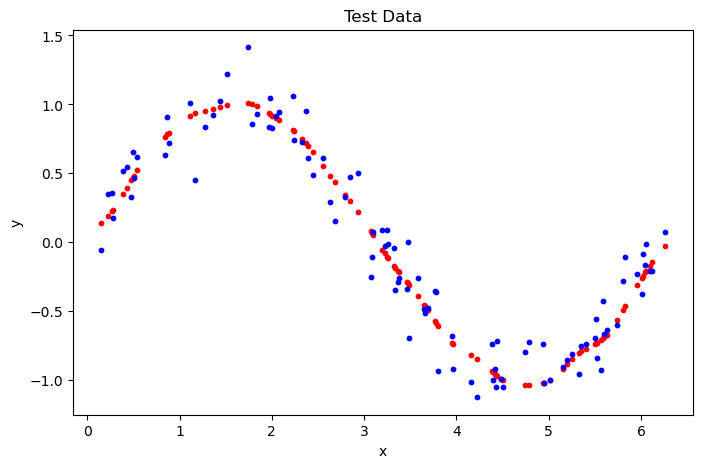

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(x_test, trained_model.forward(x_test).detach(), color='red', s=10)
plt.scatter(x_test, y_test, color='blue', s=10)
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()